# **GARCH and EGarch Models**

## **0.0 Imports**

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_white
from arch import arch_model
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

### **0.1 Load Data**

In [2]:
#Get data
ticker = yf.Ticker("USDBRL=X")


#Into df
start = '2006-01-01'
end = '2021-10-01'

df_usd = ticker.history(start=start, end = end, interval = "1d").reset_index()

#Get only close data
cols = ['Date', 'Close']
df_usd = df_usd[cols].set_index('Date')

### **0.2. Helper Function**

In [3]:

##pd.set_option('display.float_format', lambda x: '%.2f' % x)
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [13, 6]
    plt.rcParams['font.size'] = 20
    
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### **0.3 Data Visualization**

Text(0.5, 0, 'Data')

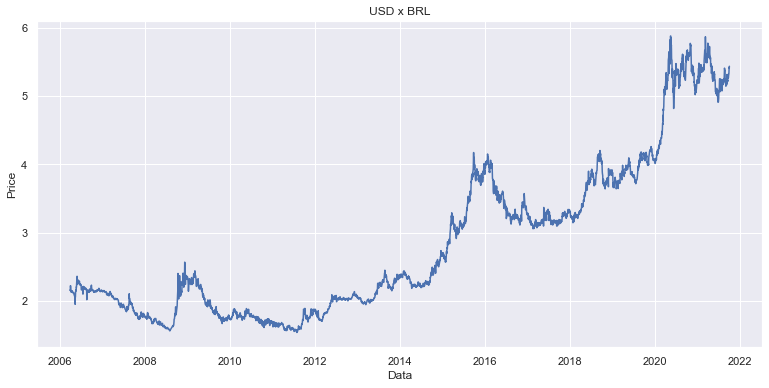

In [4]:
sns.lineplot(x = 'Date', y = 'Close', data = df_usd)
plt.title('USD x BRL')
plt.ylabel('Price')
plt.xlabel('Data')

### **0.4 Check NA**

In [5]:
df_usd.isna().sum()

Close    0
dtype: int64

# **1.0 Non-Normality Distribution of Fat Tails**    

### *The Jacque Bera is a test of whether sample data have the skewness and kurtosis matching a normal distriubtion.*

In [6]:
#Test
jarque_bera = scipy.stats.jarque_bera(df_usd['Close'])

#Test Statistic
jarque_bera.statistic

#P value
jarque_bera.pvalue


0.0

# **2.0 Serial Correlation and Unit Root**

## **2.1 PACF and ACF tests**

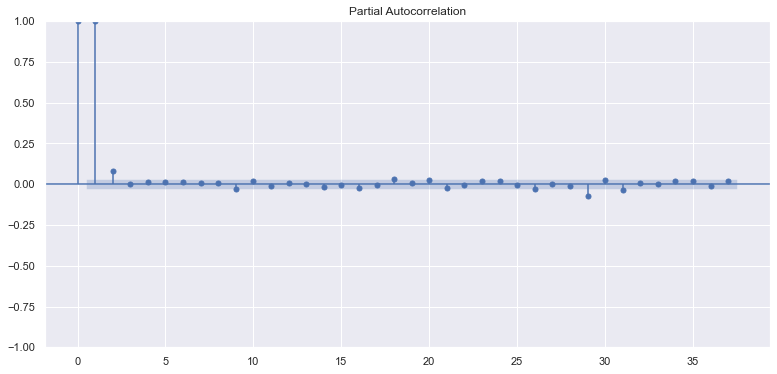

In [7]:
plot_pacf(df_usd['Close'])
plt.show()

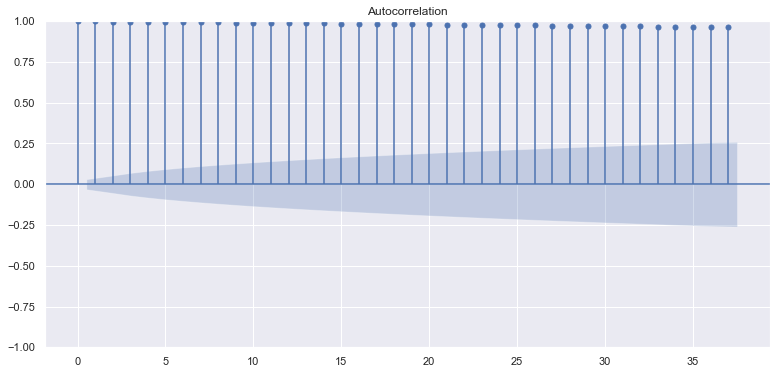

In [50]:
plot_acf(df_usd['Close'])
plt.show()

## **2.1 Stationary Tests**

### **2.1.1 Test without any differences - ADF test > -2.862 (5%): Non-stationary serie**

In [11]:
result = adfuller(df_usd['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.389959
p-value: 0.981116
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### **2.1.2 Test with one differences - ADF Test < -2.862 (5%). We have a stationary serie**

In [12]:
#Get first diff
df2 = df_usd.copy().diff()

#Dropping NA values
df2.dropna(inplace = True)

In [13]:
result_diff = adfuller(df2['Close'])
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.347032
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### **2.1.3 Test without any differences - KPSS > 0.463 (5%). Non Stationary serie**

In [14]:
result_kpss = kpss(df_usd['Close'])
print('ADF Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 8.196613
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


### **2.1.3 Test with one differences - KPSS <> 0.463 (5%).  Stationary serie**

In [15]:
result_diff_kpss = kpss(df2['Close'])
print('ADF Statistic: %f' % result_diff_kpss[0])
print('p-value: %f' % result_diff_kpss[1])
print('Critical Values:')
for key, value in result_diff_kpss[3].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.289916
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


# **3.0 Modeling**

## **3.1. The GARCH Model**


In [16]:
#Copy dataset 
df3 = df_usd.copy()

#calcuting the daily return over period
df3['return'] = 100*(df3['Close']).pct_change()


## **3.2. Plotting daily return**


Text(0.5, 0, 'Return')

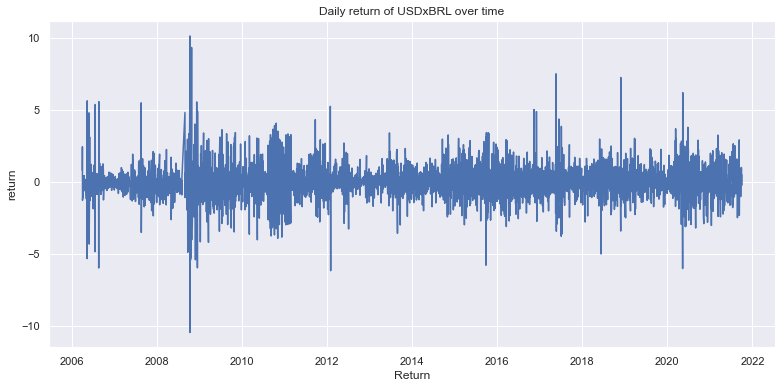

In [17]:
sns.lineplot(x = 'Date', y = 'return', data = df3);
plt.title('Daily return of USDxBRL over time')
plt.xlabel('Return')


## **3.3. Calculation of daily, monthly and annual volatility**


In [18]:
daily_volatility = df3['return'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))

monthly_volatility = math.sqrt(21) * daily_volatility
print ('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))

annual_volatility = math.sqrt(252) * daily_volatility
print ('Annual volatility: ', '{:.2f}%'.format(annual_volatility ))

Daily volatility:  1.20%
Monthly volatility:  5.51%
Annual volatility:  19.07%


## **3.4. Building a GARCH(2,2) model**


In [31]:
df3 = df_usd.copy()

#Return
df3['Return'] = 100 * df3['Close'].pct_change()
df3 = df3.dropna()

In [32]:
test_size = int(len(df3['Return']) * 0.7)

In [78]:
test_size = int(len(df3['Return']) * 0.7)

train,test = df3[:-test_size], df3[-test_size:]

#Build a Garch Model

garch_model = arch_model(df3['Return'] ** 2, p = 2, q=2, mean = 'AR', lags= 1, vol = 'GARCH', dist='normal')

gm_result = garch_model.fit()

gm_result.summary()
#print(gm_result.params)
##
#print('\n')
##
##
###Forecast
#gm_forecast = gm_result.forecast(horizon = 5)
#print(gm_forecast.variance[-1:]);

Iteration:      1,   Func. Count:      9,   Neg. LLF: 46623.312507655326
Iteration:      2,   Func. Count:     22,   Neg. LLF: 1389857.9152716256
Iteration:      3,   Func. Count:     33,   Neg. LLF: 4198994.128107667
Iteration:      4,   Func. Count:     42,   Neg. LLF: 10023.06176568178
Iteration:      5,   Func. Count:     52,   Neg. LLF: 9718.470196292386
Iteration:      6,   Func. Count:     61,   Neg. LLF: 10796.320502215633
Iteration:      7,   Func. Count:     70,   Neg. LLF: 9626.581296523145
Iteration:      8,   Func. Count:     78,   Neg. LLF: 9619.531429782044
Iteration:      9,   Func. Count:     86,   Neg. LLF: 9617.292154780615
Iteration:     10,   Func. Count:     94,   Neg. LLF: 9617.10752140568
Iteration:     11,   Func. Count:    102,   Neg. LLF: 9617.075991689588
Iteration:     12,   Func. Count:    110,   Neg. LLF: 9617.074604711202
Iteration:     13,   Func. Count:    118,   Neg. LLF: 9617.074441789246
Iteration:     14,   Func. Count:    126,   Neg. LLF: 9617.074

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.157
Mean Model:                        AR   Adj. R-squared:                  0.156
Vol Model:                      GARCH   Log-Likelihood:               -9617.07
Distribution:                  Normal   AIC:                           19248.1
Method:            Maximum Likelihood   BIC:                           19292.2
                                        No. Observations:                 4003
Date:                Tue, Oct 05 2021   Df Residuals:                     4001
Time:                        22:36:45   Df Model:                            2
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          0.6571      0.113      5.832  5.464e-09 [  0.436,  0.878]
Return[1]      0.4464      0.162      2.755  5.872e-03 [  0.129,  0.764]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.9256      0.941      3.109  1.877e-03 [  1.081,  4.770]
alpha[1]       0.2807  8.844e-02      3.174  1.505e-03 [  0.107,  0.454]
alpha[2]       0.4564      0.305      1.498      0.134 [ -0.141,  1.054]
beta[1]        0.2629      0.349      0.754      0.451 [ -0.421,  0.947]
beta[2]    6.1089e-09      0.324  1.887e-08      1.000 [ -0.634,  0.634]
========================================================================

Covariance estimator: robust
"""

In [79]:
gm_result.model

AR(constant: yes, lags: 1, no. of exog: 0, volatility: GARCH(p: 2, q: 2), distribution: Normal distribution), id: 0x26cc6b7dac0

## **3.4.0 Rolling forecast using GARCH(2,2) model**


c:\Users\victo\Music\Projetos\volatility\venv\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


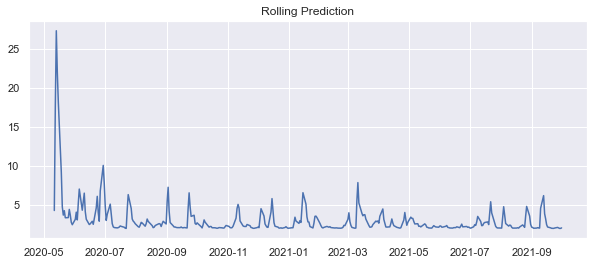

In [64]:
rolling_predictions = []
test_size = 365
retorno = df3['Return'] ** 2

for i in range(test_size):
    train = retorno[:-(test_size-i)]
    model = arch_model(train, p = 2, q=2, mean = 'AR', lags= 2, vol = 'GARCH')
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=5)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=df3['Return'].index[-365:])

plt.figure(figsize=(10,4))
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')
plt.show()

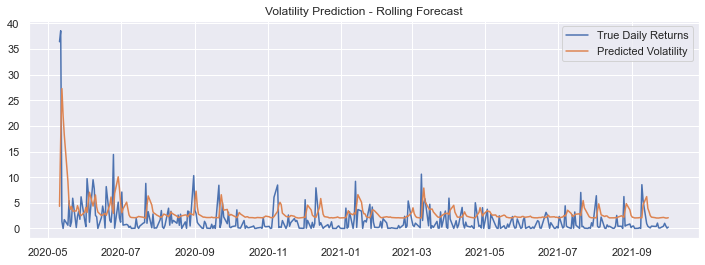

In [65]:
plt.figure(figsize=(12,4))
plt.plot(retorno[-365:])
plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])
plt.show()

## **3.5.0 ACF and PACF model training**


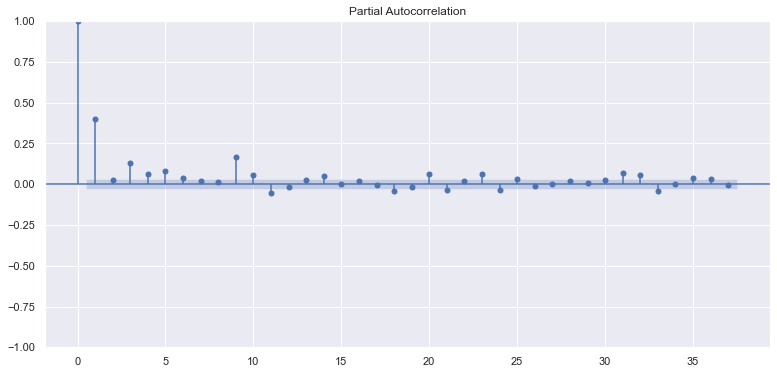

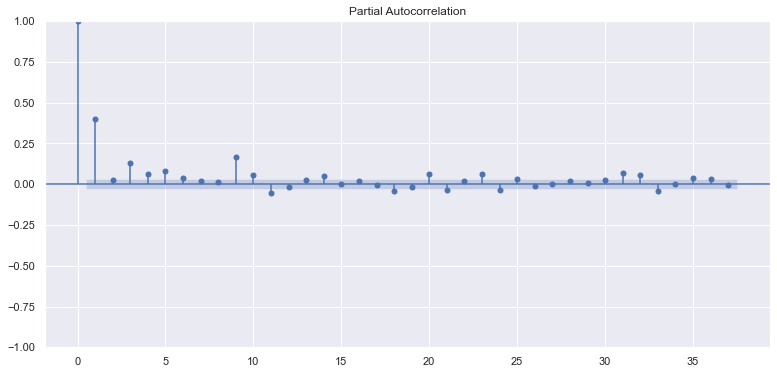

In [48]:
plot_pacf(df3['ret2'])

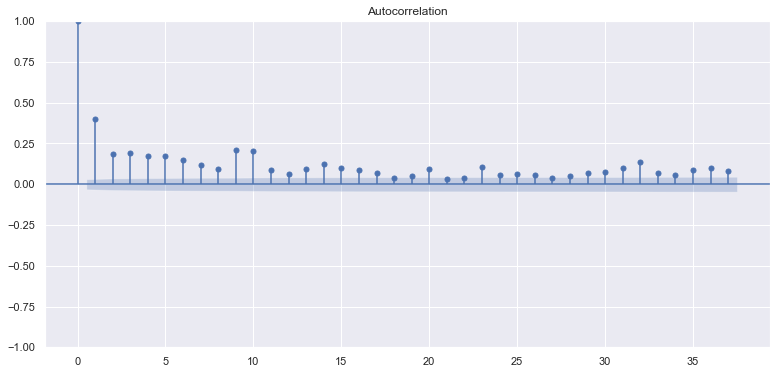

In [49]:
plot_acf(df3['ret2'])
plt.show()

In [51]:
sm.stats.acorr_ljungbox(df3['ret2'], lags = [2], return_df = True)

,lb_stat,lb_pvalue
2,773.996911,8.486061e-169


## **3.5.0 Ljung Box test for model training**


In [59]:
sm.stats.acorr_ljungbox(rolling_predictions, lags = [2], return_df = True)

,lb_stat,lb_pvalue
2,347.141819,4.160177e-76
